In this notebook we will try to cluster student performance on several test. Dataset used in this notebook can be accessed from [link](https://www.kaggle.com/datasets/phuc16102001/vietnam-highschool-exam-2017-to-2021?select=2017-2021.csv).

This quick clustering run-through will use Gaussian Mixture Model and BIC and AIC score to evaluate the optimal cluster based on model persepective.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings(action='ignore')

## Data Loading

In [2]:
df = pd.read_csv('2017-2021.csv')
df = df[df['Year']==2021].sample(3000)
df.shape

(3000, 12)

In [3]:
df.head()

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
3795988,30011816,8.6,7.25,8.00,4.25,6.0,2021,7.25,NaN,NaN,NaN,30
3656274,21021010,7.6,6.25,7.25,4.50,6.8,2021,7.75,NaN,NaN,NaN,21
3866696,37009788,5.8,4.75,NaN,NaN,4.0,2021,NaN,6.50,7.00,8.25,37
3845199,35002665,7.8,8.50,NaN,NaN,6.2,2021,NaN,9.25,9.00,9.00,35
4132222,56013070,7.0,6.00,NaN,NaN,5.6,2021,NaN,6.75,7.25,9.50,56


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 3795988 to 3873201
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SBD        3000 non-null   int64  
 1   Toan       2974 non-null   float64
 2   Van        2963 non-null   float64
 3   Ly         1043 non-null   float64
 4   Sinh       1031 non-null   float64
 5   Ngoai ngu  2649 non-null   float64
 6   Year       3000 non-null   int64  
 7   Hoa        1051 non-null   float64
 8   Lich su    1934 non-null   float64
 9   Dia ly     1917 non-null   float64
 10  GDCD       1637 non-null   float64
 11  MaTinh     3000 non-null   int64  
dtypes: float64(9), int64(3)
memory usage: 304.7 KB


In [5]:
df.describe()

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
count,3.000000e+03,2974.000000,2963.000000,1043.000000,1031.000000,2649.000000,3000.0,1051.000000,1934.000000,1917.000000,1637.000000,3000.000000
mean,2.709928e+07,6.664425,6.479362,6.581016,5.575655,5.909400,2021.0,6.640105,4.990951,7.006129,8.434942,27.082000
std,1.994704e+07,1.638723,1.352133,1.361673,1.437948,2.196373,0.0,1.589903,1.768494,1.183181,1.119522,19.958843
min,1.000627e+06,1.400000,1.250000,2.250000,1.750000,1.000000,2021.0,2.000000,1.000000,2.000000,3.750000,1.000000
25%,4.011678e+06,5.600000,5.750000,5.750000,4.500000,4.000000,2021.0,5.500000,3.500000,6.250000,7.750000,4.000000
50%,2.601766e+07,7.000000,6.500000,6.750000,5.500000,5.800000,2021.0,7.000000,4.750000,7.000000,8.750000,26.000000
75%,4.600056e+07,8.000000,7.500000,7.750000,6.500000,8.000000,2021.0,8.000000,6.250000,7.750000,9.250000,46.000000
max,6.400645e+07,9.600000,9.500000,9.250000,10.000000,10.000000,2021.0,10.000000,10.000000,10.000000,10.000000,64.000000


In [6]:
df.head(2)

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
3795988,30011816,8.6,7.25,8.00,4.25,6.0,2021,7.25,NaN,NaN,NaN,30
3656274,21021010,7.6,6.25,7.25,4.50,6.8,2021,7.75,NaN,NaN,NaN,21


In [7]:
# select numerical only
num = ['Toan','Van','Ly','Sinh','Ngoai ngu',
       'Hoa','Lich su','Dia ly','GDCD']

dfc = df[num]

In [8]:
dfc.isnull().sum() / dfc.shape[0] * 100

Toan          0.866667
Van           1.233333
Ly           65.233333
Sinh         65.633333
Ngoai ngu    11.700000
Hoa          64.966667
Lich su      35.533333
Dia ly       36.100000
GDCD         45.433333
dtype: float64

In [9]:
# drop columns with high proportion of MV (>40%)
dfc.drop(['Ly', 'Sinh', 'Hoa', 'GDCD'], axis=1, inplace=True)

In [10]:
# drop rows with MV
dfc.dropna(axis=0, inplace=True)

In [11]:
dfc.isnull().sum() / dfc.shape[0] * 100

Toan         0.0
Van          0.0
Ngoai ngu    0.0
Lich su      0.0
Dia ly       0.0
dtype: float64

In [12]:
X = dfc.copy()

In [13]:
clus_sample = dfc.index.tolist()

## EDA ANALYSIS

In [14]:
# cek korelasi antara setiap mapel
# dsb
dfc.shape

(1631, 5)

In [15]:
# check skewness
for i in dfc.columns:
    print(i, ': ', dfc[i].skew())

Toan :  -0.49547500012767054
Van :  -0.5399362274670747
Ngoai ngu :  0.4274070999543684
Lich su :  0.33132035785197855
Dia ly :  -0.37278366347513825


In [16]:
# check outlier
wins_gauss = Winsorizer(capping_method='gaussian', fold=3, tail='both')
dfc = wins_gauss.fit_transform(dfc)

In [17]:
# scaling
scaler = StandardScaler()
dfc = pd.DataFrame(scaler.fit_transform(dfc))
dfc.head()

,0,1,2,3,4
0,-0.283497,-1.405674,-0.648625,0.814690,-0.100761
1,1.042904,1.396206,0.373149,2.380113,1.686748
2,0.512344,-0.471714,0.094483,0.957001,0.122678
3,0.910264,-0.284922,0.373149,-1.177666,0.346116
4,-0.946697,-1.405674,-1.484622,-1.604600,-1.217954


In [18]:
# check VIF
# -----

In [19]:
# PCA
pca = PCA()
pca.fit(dfc)

np.cumsum(pca.explained_variance_ratio_)
# check elbow with visualization

array([0.58231566, 0.75193188, 0.85216189, 0.93207446, 1.        ])

In [20]:
pca = PCA(n_components=.90)
dfc = pd.DataFrame(pca.fit_transform(dfc))
dfc


,0,1,2,3
0,0.741629,1.145318,0.990387,0.263310
1,-3.056247,1.374698,-0.349679,0.116806
2,-0.538520,0.496044,0.747238,0.188325
3,-0.109646,-0.909871,0.566095,-1.063748
4,2.964708,-0.176636,0.137362,-0.538984
...,...,...,...,...
1626,-0.828962,-0.483590,-0.263230,-0.037062
1627,-0.647332,-1.401918,-0.426939,-0.042157
1628,0.796582,0.489730,-0.003902,0.160002
1629,-0.049500,-1.157960,-0.827464,-0.006071


<AxesSubplot:xlabel='0', ylabel='1'>

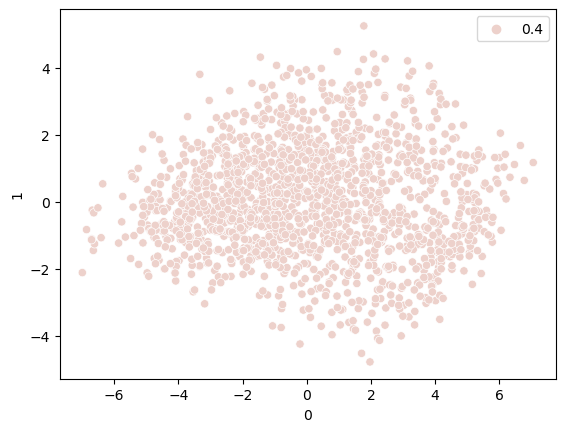

In [21]:
# for visualization, only 2 PC's saved
pca_viz = PCA(n_components=2)
X_viz = pd.DataFrame(pca_viz.fit_transform(X))
sns.scatterplot(X_viz[0], X_viz[1],hue=0.4)

## Preprocess

In [22]:
pipe = Pipeline([
    ('wins', Winsorizer(capping_method='gaussian', fold=3, tail='both')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=.90))
])

In [23]:
X.head(3)

,Toan,Van,Ngoai ngu,Lich su,Dia ly
3866696,5.8,4.75,4.0,6.50,7.00
3845199,7.8,8.50,6.2,9.25,9.00
4132222,7.0,6.00,5.6,6.75,7.25


In [24]:
X_tr = pipe.fit_transform(X)
X_tr

array([[ 0.74162877,  1.14531802,  0.99038668,  0.26330973],
       [-3.0562473 ,  1.37469848, -0.34967911,  0.11680637],
       [-0.53852014,  0.496044  ,  0.74723789,  0.18832456],
       ...,
       [ 0.79658246,  0.48972966, -0.00390246,  0.16000174],
       [-0.04950006, -1.15796009, -0.82746393, -0.00607052],
       [ 0.76984133, -1.17801938, -0.76908144, -1.42131092]])

## Modeling

In [25]:
# Get Best Cluster and Best Hyperparameter
# You can think of the code below as GridSearchCV process on Supervised Learning
min_aic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        aic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X_tr).aic(X_tr)
        if aic < min_aic:
            min_aic = aic
            best_k = k
            best_covariance_type = covariance_type

print('Best - n_components    : ', best_k)
print('Best - covariance_type : ', best_covariance_type)

Best - n_components    :  8
Best - covariance_type :  full


Based on model's perspective, the optimal cluster was 8 with `full` covariance type.

However from user perspective, 8 cluster is too much. They expect maximum number of cluster is 5. so let's rerun our hyperparameter test with maximum 5 clusters.

In [26]:
models = [GaussianMixture(n_components=k, covariance_type='full') for k in range(2,6)]
aic = [model.fit(X_tr).aic(X_tr) for model in models]

for k, skor in zip(range(2,6), aic):
    print(k, ': ', skor)

2 :  17033.87787939101
3 :  16944.893732010027
4 :  16925.06864117879
5 :  16913.418081427455


In [27]:
k_5 = GaussianMixture(n_components=5)
labelz = k_5.fit_predict(X_tr)
labelz

array([3, 1, 3, ..., 2, 2, 2])

<AxesSubplot:xlabel='0', ylabel='1'>

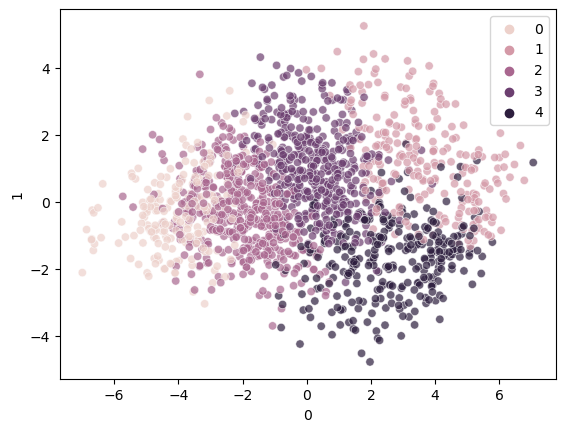

In [28]:
# visualize segmentation of 5 cluster in 2 PC's
sns.scatterplot(X_viz[0], X_viz[1], hue=labelz, alpha=.7)

<AxesSubplot:xlabel='0', ylabel='1'>

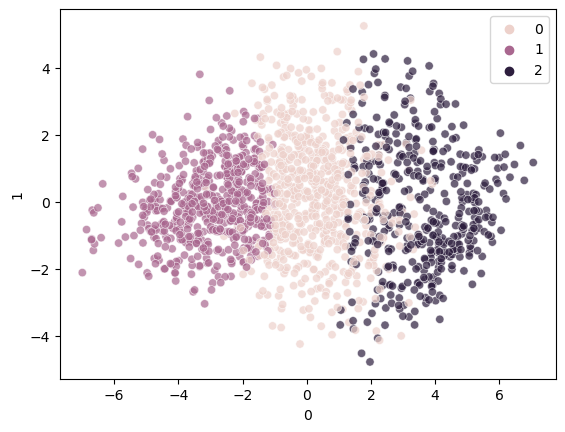

In [29]:
# you can try to visualize other n_cluster to see which one gives better separation
k_3 = GaussianMixture(n_components=3)
label3 = k_3.fit_predict(X_tr)

# visualize segmentation of 5 cluster in 2 PC's
sns.scatterplot(X_viz[0], X_viz[1], hue=label3, alpha=.7)

## EDA CLuster

In [30]:
df_eda = df.loc[clus_sample].copy()
df_eda

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
3866696,37009788,5.8,4.75,NaN,NaN,4.0,2021,NaN,6.50,7.00,8.25,37
3845199,35002665,7.8,8.50,NaN,NaN,6.2,2021,NaN,9.25,9.00,9.00,35
4132222,56013070,7.0,6.00,NaN,NaN,5.6,2021,NaN,6.75,7.25,9.50,56
3392453,2018061,7.6,6.25,NaN,NaN,6.2,2021,NaN,3.00,7.50,9.50,2
3327809,1053896,4.8,4.75,NaN,NaN,2.2,2021,NaN,2.25,5.75,5.75,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3699278,25010006,6.4,7.50,NaN,NaN,7.2,2021,NaN,4.50,7.75,9.75,25
3792949,30008887,7.6,8.00,NaN,NaN,6.6,2021,NaN,4.50,6.25,7.25,30
3822374,33009151,5.2,6.00,NaN,NaN,4.4,2021,NaN,5.00,7.00,8.50,33
3648769,21013583,6.6,8.00,NaN,NaN,5.8,2021,NaN,4.00,6.25,8.75,21


In [31]:
df_eda['cluster'] = label3
df_eda

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh,cluster
3866696,37009788,5.8,4.75,NaN,NaN,4.0,2021,NaN,6.50,7.00,8.25,37,0
3845199,35002665,7.8,8.50,NaN,NaN,6.2,2021,NaN,9.25,9.00,9.00,35,2
4132222,56013070,7.0,6.00,NaN,NaN,5.6,2021,NaN,6.75,7.25,9.50,56,0
3392453,2018061,7.6,6.25,NaN,NaN,6.2,2021,NaN,3.00,7.50,9.50,2,0
3327809,1053896,4.8,4.75,NaN,NaN,2.2,2021,NaN,2.25,5.75,5.75,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3699278,25010006,6.4,7.50,NaN,NaN,7.2,2021,NaN,4.50,7.75,9.75,25,2
3792949,30008887,7.6,8.00,NaN,NaN,6.6,2021,NaN,4.50,6.25,7.25,30,2
3822374,33009151,5.2,6.00,NaN,NaN,4.4,2021,NaN,5.00,7.00,8.50,33,1
3648769,21013583,6.6,8.00,NaN,NaN,5.8,2021,NaN,4.00,6.25,8.75,21,0


In [32]:
# for example purpose, using .describe
df_eda.groupby('cluster').mean()
# for graded challenge, utilizing visualization in EDA:_clustering_result is a must

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
cluster,,,,,,,,,,,,
0,2.738325e+07,6.439077,6.787923,NaN,NaN,5.431692,2021.0,NaN,5.285385,7.229231,8.632512,27.367692
1,3.030084e+07,4.841145,5.509302,NaN,NaN,3.488730,2021.0,NaN,3.754472,6.302326,7.708333,30.286225
2,2.478240e+07,7.737915,7.870071,NaN,NaN,7.869668,2021.0,NaN,6.476303,7.997630,9.090855,24.765403


- make personalization for each cluster based on its character
- utilize cluster information to make strategy

**personalization**:
- cluster 0: moderate
- cluster 1: slow learner
- cluster 2: high-achiever

**strategy**:
- make peer-study-group consist of 5 students with proportion 2:2:1 from cluster 0:2:1